In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 데이터 로드
data = pd.read_csv('../data/secom_preprocessed.csv')
X = data.drop(columns=['label'])
y = data['label']

# 레이블 -1 → 0으로 변환
y = y.map({-1: 0, 1: 1})

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 후 레이블 분포:")
print(pd.Series(y_train_resampled).value_counts())

# XGBoost 학습
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost 성능 평가 ===")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Defect']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

SMOTE 적용 후 레이블 분포:
label
0    1170
1    1170
Name: count, dtype: int64

=== XGBoost 성능 평가 ===
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96       293
      Defect       0.00      0.00      0.00        21

    accuracy                           0.92       314
   macro avg       0.47      0.49      0.48       314
weighted avg       0.87      0.92      0.89       314

ROC-AUC: 0.7049


In [10]:
# 임계값 조정으로 Recall 향상
threshold = 0.3  # 기본 0.5에서 낮춤

y_pred_adjusted = (y_prob >= threshold).astype(int)

print(f"=== XGBoost 임계값 {threshold} 적용 ===")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'Defect']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

=== XGBoost 임계값 0.3 적용 ===
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       293
      Defect       0.20      0.10      0.13        21

    accuracy                           0.91       314
   macro avg       0.57      0.53      0.54       314
weighted avg       0.89      0.91      0.90       314

ROC-AUC: 0.7049


In [11]:
# 여러 임계값 테스트해서 최적값 찾기
from sklearn.metrics import f1_score, recall_score, precision_score

thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    results.append({
        'threshold': t,
        'defect_precision': precision_score(y_test, y_pred_t, pos_label=1, zero_division=0).round(3),
        'defect_recall': recall_score(y_test, y_pred_t, pos_label=1, zero_division=0).round(3),
        'defect_f1': f1_score(y_test, y_pred_t, pos_label=1, zero_division=0).round(3),
        'roc_auc': roc_auc_score(y_test, y_prob).round(4)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 threshold  defect_precision  defect_recall  defect_f1  roc_auc
      0.10             0.200          0.333      0.250   0.7049
      0.15             0.190          0.190      0.190   0.7049
      0.20             0.125          0.095      0.108   0.7049
      0.25             0.167          0.095      0.121   0.7049
      0.30             0.200          0.095      0.129   0.7049
      0.35             0.143          0.048      0.071   0.7049
      0.40             0.200          0.048      0.077   0.7049
      0.50             0.000          0.000      0.000   0.7049


In [12]:
from sklearn.ensemble import IsolationForest

# Isolation Forest는 정상 데이터만으로 학습
X_train_normal = X_train[y_train == 0]

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.066,  # 불량 비율 6.6% 반영
    random_state=42
)
iso_forest.fit(X_train_normal)

# 예측 (-1: 이상, 1: 정상) → (1: 불량, 0: 정상)으로 변환
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = (y_pred_iso == -1).astype(int)

print("=== Isolation Forest 성능 평가 ===")
print(classification_report(y_test, y_pred_iso, target_names=['Normal', 'Defect']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_iso):.4f}")

=== Isolation Forest 성능 평가 ===
              precision    recall  f1-score   support

      Normal       0.94      0.93      0.93       293
      Defect       0.16      0.19      0.17        21

    accuracy                           0.88       314
   macro avg       0.55      0.56      0.55       314
weighted avg       0.89      0.88      0.88       314

ROC-AUC: 0.5594


In [13]:
# 앙상블: XGBoost 확률 + Isolation Forest 점수 결합
iso_scores = iso_forest.decision_function(X_test)

# 정규화 (0~1 범위로)
from sklearn.preprocessing import MinMaxScaler
scaler_iso = MinMaxScaler()
iso_scores_normalized = scaler_iso.fit_transform(iso_scores.reshape(-1, 1)).flatten()
iso_scores_inverted = 1 - iso_scores_normalized  # 낮을수록 이상 → 높을수록 불량

# XGBoost 확률과 평균 결합
ensemble_prob = (y_prob + iso_scores_inverted) / 2

# 여러 임계값 테스트
results_ensemble = []
for t in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]:
    y_pred_e = (ensemble_prob >= t).astype(int)
    results_ensemble.append({
        'threshold': t,
        'defect_precision': precision_score(y_test, y_pred_e, pos_label=1, zero_division=0).round(3),
        'defect_recall': recall_score(y_test, y_pred_e, pos_label=1, zero_division=0).round(3),
        'defect_f1': f1_score(y_test, y_pred_e, pos_label=1, zero_division=0).round(3),
        'roc_auc': roc_auc_score(y_test, ensemble_prob).round(4)
    })

results_ensemble_df = pd.DataFrame(results_ensemble)
print("=== 앙상블 결과 ===")
print(results_ensemble_df.to_string(index=False))

=== 앙상블 결과 ===
 threshold  defect_precision  defect_recall  defect_f1  roc_auc
      0.10             0.078          0.952      0.144   0.6758
      0.15             0.085          0.762      0.152   0.6758
      0.20             0.124          0.571      0.203   0.6758
      0.25             0.154          0.381      0.219   0.6758
      0.30             0.161          0.238      0.192   0.6758
      0.35             0.211          0.190      0.200   0.6758
      0.40             0.273          0.143      0.188   0.6758
      0.50             0.400          0.095      0.154   0.6758


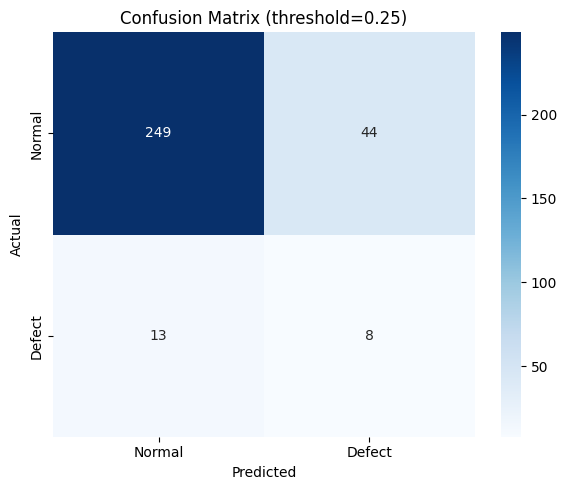

=== 최종 성능 (threshold=0.25) ===
              precision    recall  f1-score   support

      Normal       0.95      0.85      0.90       293
      Defect       0.15      0.38      0.22        21

    accuracy                           0.82       314
   macro avg       0.55      0.62      0.56       314
weighted avg       0.90      0.82      0.85       314

ROC-AUC: 0.6758


In [14]:
from sklearn.metrics import confusion_matrix

# 최적 임계값 0.25 적용
best_threshold = 0.25
y_pred_final = (ensemble_prob >= best_threshold).astype(int)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Defect'],
            yticklabels=['Normal', 'Defect'])
plt.title(f'Confusion Matrix (threshold={best_threshold})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('../reports/confusion_matrix.png', dpi=150)
plt.show()

print(f"=== 최종 성능 (threshold={best_threshold}) ===")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Defect']))
print(f"ROC-AUC: {roc_auc_score(y_test, ensemble_prob):.4f}")

In [15]:
import joblib
import os

# models 폴더 생성
os.makedirs('../models', exist_ok=True)

# 모델 저장
joblib.dump(xgb, '../models/xgb_model.pkl')
joblib.dump(iso_forest, '../models/iso_forest.pkl')
joblib.dump(scaler_iso, '../models/scaler_iso.pkl')

# 전처리에 사용한 컬럼 목록 저장 (나중에 새 데이터 전처리할 때 필요)
feature_cols = X_train.columns.tolist()
joblib.dump(feature_cols, '../models/feature_cols.pkl')

print("모델 저장 완료!")
print("저장된 파일:")
for f in os.listdir('../models'):
    print(f"  - {f}")

모델 저장 완료!
저장된 파일:
  - feature_cols.pkl
  - iso_forest.pkl
  - scaler_iso.pkl
  - xgb_model.pkl
